In [1]:
import argparse
import cv2
import numpy as np
import os
import torch
import torch.nn.functional as F
from torchvision.transforms import Compose
from tqdm import tqdm
from path import Path
from path import Path
from tqdm.contrib import tzip

from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

import matplotlib.pyplot as plt

/home/jiahan/miniconda3/envs/depth-anything/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def RMSE_func(gt,pred):
    return np.sqrt(np.mean((gt-pred)**2))

def MAE_func(gt,pred):
    return abs(gt-pred).mean()


def Rel_func2(gt,pred):
    """rel in paper SimCol3D using median

    Args:
        gt (_type_): _description_
        pred (_type_): _description_

    Returns:
        _type_: _description_
    """
    mask = gt>0
    return np.median(abs(gt-pred)/(gt+1e-5))



In [3]:
# 加载模型
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

depth_anything = DepthAnything.from_pretrained('./checkpoints/depth_anything_vitl14', local_files_only=True).to(DEVICE)

transform = Compose([
        Resize(
            width=518,
            height=518,
            resize_target=False,
            keep_aspect_ratio=True,
            ensure_multiple_of=14,
            resize_method='lower_bound',
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        PrepareForNet(),
    ])

# tmp = torch.load("/home/jiahan/jiahan/codes/Depth-Anything/log/C3VD/03-20-19:43/checkpoints/0.pth.tar")
# tmp = torch.load("log/C3VD/03-24-22:07/checkpoints/0.pth.tar")
# tmp = torch.load("/home/jiahan/jiahan/codes/Depth-Anything/log/C3VD/03-25-23:11/checkpoints/4.pth.tar") # 88.8
# tmp = torch.load("/home/jiahan/jiahan/codes/Depth-Anything/log/C3VD/03-27-00:54/checkpoints/1.pth.tar") # 166.6
# tmp = torch.load("/home/jiahan/jiahan/codes/Depth-Anything/log/C3VD/03-29-00:23/checkpoints/2.pth.tar") # 166.6
tmp = torch.load("log/UCL/03-30-13:04/checkpoints/0.pth.tar") # 22.2 UCL
depth_anything.load_state_dict(tmp)


xFormers not available
xFormers not available


Loading weights from local directory


<All keys matched successfully>

In [4]:


def infer(filename):
    raw_image = cv2.imread(filename)
    image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB) / 255.0
    
    h, w = image.shape[:2]
    
    image = transform({'image': image})['image']
    image = torch.from_numpy(image).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        depth = depth_anything(image)
    
    
    depth = F.interpolate(depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]
    # depth = (depth - depth.min()) / (depth.max() - depth.min())
    depth = depth.cpu().numpy()
    
    return depth

def infer_inv(filename):
    raw_image = cv2.imread(filename)
    image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB) / 255.0
    
    h, w = image.shape[:2]
    
    image = transform({'image': image})['image']
    image = torch.from_numpy(image).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        depth = depth_anything(image)
    
    
    depth = F.interpolate(depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]
    depth = depth.cpu().numpy()
    
    return depth



### 推理图片

(475, 475)
213.82117 1.7771595


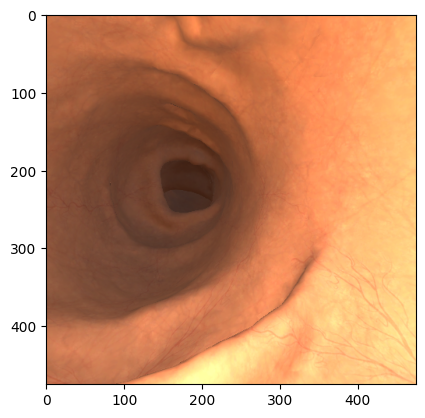

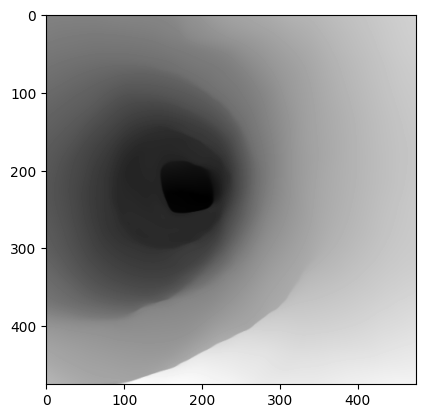

: 

In [10]:
import matplotlib.pyplot as plt

pred = infer_inv("/home/jiahan/jiahan/datasets/SimCol/SimCol3D4SC_Depth/SyntheticColon_I/Frames_S1/FrameBuffer_0010.png")
print(pred.shape)
print(pred.max(),pred.min())

plt.imshow(plt.imread("/home/jiahan/jiahan/datasets/SimCol/SimCol3D4SC_Depth/SyntheticColon_I/Frames_S1/FrameBuffer_0010.png"))
plt.figure()
plt.imshow(pred, cmap='gray')


In [16]:
RMSEs, MAEs, AbsRels = [], [], []

for scene in scenes[:1]:
    print("=> processing ", scene)
    rgbs = sorted(scene.listdir("F*.png"))
    gts = sorted( (scene/'depth_gt').listdir("*.npy") )
    
    for rgb_name,gt_name in tzip(rgbs,gts):
        gt_depth = np.load(gt_name)
        pred_depth = 1.0 - infer(rgb_name)

        scale = np.median(gt_depth)/np.median(pred_depth)
        pred_depth *= scale

        RMSEs.append(RMSE_func(gt_depth,pred_depth))
        MAEs.append(MAE_func(gt_depth,pred_depth))
        AbsRels.append(Rel_func2(gt_depth,pred_depth))


/tmp/ipykernel_111915/401128939.py:5: DeprecationWarning: .listdir is deprecated; use iterdir
  rgbs = sorted(scene.listdir("F*.png"))
/tmp/ipykernel_111915/401128939.py:6: DeprecationWarning: .listdir is deprecated; use iterdir
  gts = sorted( (scene/'depth_gt').listdir("*.npy") )


=> processing  /root/autodl-tmp/datasets/SimCol/SyntheticColon_I/Frames_S15


  0%|          | 0/1201 [00:00<?, ?it/s]

100%|██████████| 1201/1201 [1:29:56<00:00,  4.49s/it]


In [17]:
print("=> RMSE is ", sum(RMSEs)/len(RMSEs))
print("=> MAE is ", sum(MAEs)/len(MAEs))
print("=> AbsRel is ", sum(AbsRels)/len(AbsRels))

=> RMSE is  8.312208053526486
=> MAE is  5.1197104110234
=> AbsRel is  0.15721975583792164


### 从文件中读取并统计

In [7]:
import matplotlib.pyplot as plt

def read_scene(lines, start):
    RMSE, MAE, AbsRel = [], [], []
    names = []
    
    name = lines[start][:-1]
    
    start += 2
    line = lines[start][:-1]
    line = line[1:-1]
    RMSE = line.split(", ")
    RMSE = [float(i) for i in RMSE]
    # print(RMSE)
    
    start += 2
    line = lines[start][:-1]
    line = line[1:-1]
    MAE = line.split(", ")
    MAE = [float(i) for i in MAE]
    # print(MAE)
    
    start += 2
    line = lines[start][:-1]
    line = line[1:-1]
    AbsRel = line.split(", ")
    AbsRel = [float(i) for i in AbsRel]
    # print(AbsRel)
    
    return start, name, RMSE,MAE,AbsRel

with open("C3VD_all.txt", 'r') as f:
    lines = f.readlines()

RMSE_scenes, MAE_scenes, AbsRel_scenes = [], [], []
names = []
start = 4
while(start < len(lines)):
    start,name, RMSE,MAE,AbsRel = read_scene(lines, start)
    names.append(name)
    RMSE_scenes.append(RMSE)
    MAE_scenes.append(MAE)
    AbsRel_scenes.append(AbsRel)
    start += 4
    

In [17]:
RMSE_all = [i for j in RMSE_scenes for i in j]
MAE_all = [i for j in MAE_scenes for i in j]
AbsRel_all = [i for j in AbsRel_scenes for i in j]

print("=> RMSE is ", sum(RMSE_all)/len(RMSE_all))
print("=> MAE is ", sum(MAE_all)/len(MAE_all))
print("=> AbsRel is ", sum(AbsRel_all)/len(AbsRel_all))

print("============ scenes =================")
print()
print("SyntheticColon_I")
RMSE_one = [i for j in RMSE_scenes[:15] for i in j]
MAE_one = [i for j in MAE_scenes[:15] for i in j]
AbsRel_one = [i for j in AbsRel_scenes[:15] for i in j]
print("=> RMSE is ", sum(RMSE_one)/len(RMSE_one))
print("=> MAE is ", sum(MAE_one)/len(MAE_one))
print("=> AbsRel is ", sum(AbsRel_one)/len(AbsRel_one))


print()
print("SyntheticColon_II")
RMSE_one = [i for j in RMSE_scenes[15:30] for i in j]
MAE_one = [i for j in MAE_scenes[15:30] for i in j]
AbsRel_one = [i for j in AbsRel_scenes[15:30] for i in j]
print("=> RMSE is ", sum(RMSE_one)/len(RMSE_one))
print("=> MAE is ", sum(MAE_one)/len(MAE_one))
print("=> AbsRel is ", sum(AbsRel_one)/len(AbsRel_one))

print()
print("SyntheticColon_III")
RMSE_one = [i for j in RMSE_scenes[30:] for i in j]
MAE_one = [i for j in MAE_scenes[30:] for i in j]
AbsRel_one = [i for j in AbsRel_scenes[30:] for i in j]
print("=> RMSE is ", sum(RMSE_one)/len(RMSE_one))
print("=> MAE is ", sum(MAE_one)/len(MAE_one))
print("=> AbsRel is ", sum(AbsRel_one)/len(AbsRel_one))


=> RMSE is  8.578354452737543
=> MAE is  5.722570618786024
=> AbsRel is  0.16000701472101406
============ scenes =================

SyntheticColon_I
=> RMSE is  8.530772731041914
=> MAE is  5.274618581509254
=> AbsRel is  0.16054049756554906

SyntheticColon_II
=> RMSE is  8.683911959427435
=> MAE is  6.154977785135177
=> AbsRel is  0.1599396319536525

SyntheticColon_III
=> RMSE is  7.999078930456982
=> MAE is  5.877890003013316
=> AbsRel is  0.15534989165374302


In [9]:
RMSE_all = [i for j in RMSE_scenes for i in j]
MAE_all = [i for j in MAE_scenes for i in j]
AbsRel_all = [i for j in AbsRel_scenes for i in j]

print("=> RMSE is ", sum(RMSE_all)/len(RMSE_all))
print("=> MAE is ", sum(MAE_all)/len(MAE_all))
print("=> AbsRel is ", sum(AbsRel_all)/len(AbsRel_all))

print("============ scenes =================")
print()
print("cecum")
RMSE_one = [i for j in RMSE_scenes[:3] for i in j]
MAE_one = [i for j in MAE_scenes[:3] for i in j]
AbsRel_one = [i for j in AbsRel_scenes[:3] for i in j]
print("=> RMSE is ", sum(RMSE_one)/len(RMSE_one))
print("=> MAE is ", sum(MAE_one)/len(MAE_one))
print("=> AbsRel is ", sum(AbsRel_one)/len(AbsRel_one))


print()
print("trans")
RMSE_one = [i for j in RMSE_scenes[3:11] for i in j]
MAE_one = [i for j in MAE_scenes[3:11] for i in j]
AbsRel_one = [i for j in AbsRel_scenes[3:11] for i in j]
print("=> RMSE is ", sum(RMSE_one)/len(RMSE_one))
print("=> MAE is ", sum(MAE_one)/len(MAE_one))
print("=> AbsRel is ", sum(AbsRel_one)/len(AbsRel_one))

print()
print("sigmoid")
RMSE_one = [i for j in RMSE_scenes[11:15] for i in j]
MAE_one = [i for j in MAE_scenes[11:15] for i in j]
AbsRel_one = [i for j in AbsRel_scenes[11:15] for i in j]
print("=> RMSE is ", sum(RMSE_one)/len(RMSE_one))
print("=> MAE is ", sum(MAE_one)/len(MAE_one))
print("=> AbsRel is ", sum(AbsRel_one)/len(AbsRel_one))

print()
print("desc")
RMSE_one = [i for j in RMSE_scenes[15:] for i in j]
MAE_one = [i for j in MAE_scenes[15:] for i in j]
AbsRel_one = [i for j in AbsRel_scenes[15:] for i in j]
print("=> RMSE is ", sum(RMSE_one)/len(RMSE_one))
print("=> MAE is ", sum(MAE_one)/len(MAE_one))
print("=> AbsRel is ", sum(AbsRel_one)/len(AbsRel_one))


=> RMSE is  9.65571445533185
=> MAE is  7.500698695342751
=> AbsRel is  0.22732843731327323
============ scenes =================

cecum
=> RMSE is  16.109784454649976
=> MAE is  13.369101367176071
=> AbsRel is  0.2996303342187221

trans
=> RMSE is  8.08633002375834
=> MAE is  6.045506333126
=> AbsRel is  0.21127643475018074

sigmoid
=> RMSE is  7.2354329306056115
=> MAE is  5.419003631214421
=> AbsRel is  0.19936412560850578

desc
=> RMSE is  9.448591300102054
=> MAE is  5.820872542371259
=> AbsRel is  0.2164968529026792


## C3VD数据集

In [5]:
scenes = [
    "scene_cecum_t1_a",
    "scene_cecum_t1_b",
    "scene_cecum_t2_a",
    "scene_cecum_t2_b",
    "scene_cecum_t2_c",
    "scene_cecum_t3_a",
    "scene_cecum_t4_a",
    "scene_cecum_t4_b",
    "scene_trans_t1_a",
    "scene_trans_t1_b",
    "scene_trans_t2_a",
    "scene_trans_t2_b",
    "scene_trans_t2_c",
    "scene_trans_t3_a",
    "scene_trans_t3_b",
    "scene_trans_t4_a",
    "scene_trans_t4_b",
    "scene_sigmoid_t1_a",
    "scene_sigmoid_t2_a",
    "scene_sigmoid_t3_a",
    "scene_sigmoid_t3_b",
    "scene_desc_t4_a"

    # "scene_cecum_t1_a",
    # "scene_cecum_t2_a",
    # "scene_cecum_t3_a",
    # "scene_sigmoid_t3_a",
    # "scene_trans_t2_a",
    # "scene_trans_t3_a",
    # "scene_trans_t4_a"

    ]

def verbose_C3VD(RMSE_of_scenes,MAE_of_scenes,AbsRel_of_scenes):
        

    RMSE_sum, MAE_sum, AbsRel_sum, count = 0.0, 0.0, 0.0, 0

    RMSE_cecum_sum, MAE_cecum_sum, AbsRel_cecum_sum, count_cecum = 0.0, 0.0, 0.0, 0
    RMSE_desc_sum, MAE_desc_sum, AbsRel_desc_sum, count_desc = 0.0, 0.0, 0.0, 0
    RMSE_sigmoid_sum, MAE_sigmoid_sum, AbsRel_sigmoid_sum, count_sigmoid = 0.0, 0.0, 0.0, 0
    RMSE_trans_sum, MAE_trans_sum, AbsRel_trans_sum, count_trans = 0.0, 0.0, 0.0, 0

    for p,RMSEs,MAEs,AbsRels in zip(scenes,RMSE_of_scenes,MAE_of_scenes,AbsRel_of_scenes):
        if(len(RMSEs)==0): continue
        name = p.split('/')[-1]
        print("\nscene of ", name)
        print("=> RMSE is ", sum(RMSEs)/len(RMSEs), 'mm')
        print("=> MAE is ", sum(MAEs)/len(MAEs), 'mm')
        print("=> AbsRel is ", sum(AbsRels)/len(AbsRels), 'mm')
        RMSE_sum += sum(RMSEs)
        MAE_sum += sum(MAEs)
        AbsRel_sum += sum(AbsRels)
        count += len(RMSEs)

        part_name = name.split('_')[1]
        if part_name == 'cecum':
            RMSE_cecum_sum += sum(RMSEs)
            MAE_cecum_sum += sum(MAEs)
            AbsRel_cecum_sum += sum(AbsRels)
            count_cecum += len(RMSEs)
        elif part_name == 'desc':
            RMSE_desc_sum += sum(RMSEs)
            MAE_desc_sum += sum(MAEs)
            AbsRel_desc_sum += sum(AbsRels)
            count_desc += len(RMSEs)
        elif part_name == 'sigmoid':
            RMSE_sigmoid_sum += sum(RMSEs)
            MAE_sigmoid_sum += sum(MAEs)
            AbsRel_sigmoid_sum += sum(AbsRels)
            count_sigmoid += len(RMSEs)
        elif part_name == 'trans':
            RMSE_trans_sum += sum(RMSEs)
            MAE_trans_sum += sum(MAEs)
            AbsRel_trans_sum += sum(AbsRels)
            count_trans += len(RMSEs)

    print("\n C3VD numbers is ", count)

    print("\n each part")
    print("\n ----- cecum ------")
    print("=> RMSE is ", RMSE_cecum_sum/count_cecum, 'mm')
    print("=> MAE is ", MAE_cecum_sum/count_cecum, 'mm')
    print("=> AbsRel is ", AbsRel_cecum_sum/count_cecum)

    #print("\n ----- desc ------")
    #print("=> RMSE is ", RMSE_desc_sum/count_desc, 'mm')
    #print("=> MAE is ", MAE_desc_sum/count_desc, 'mm')
    #print("=> AbsRel is ", AbsRel_desc_sum/count_desc)

    print("\n ----- sigmoid ------")
    print("=> RMSE is ", RMSE_sigmoid_sum/count_sigmoid, 'mm')
    print("=> MAE is ", MAE_sigmoid_sum/count_sigmoid, 'mm')
    print("=> AbsRel is ", AbsRel_sigmoid_sum/count_sigmoid)

    print("\n ----- trans ------")
    print("=> RMSE is ", RMSE_trans_sum/count_trans, 'mm')
    print("=> MAE is ", MAE_trans_sum/count_trans, 'mm')
    print("=> AbsRel is ", AbsRel_trans_sum/count_trans)

    print("\n ----- all dataset -----")
    print("=> RMSE is ", RMSE_sum/count, 'mm')
    print("=> MAE is ", MAE_sum/count, 'mm')
    print("=> AbsRel is ", AbsRel_sum/count)


In [6]:
# 几种转换方式

def c3vd_train_converte(output,gt):
    return 1/(output+22.2)
    # return 1/(output+44.4)
    # return 1/(output+88.8)
    # return 1/(output+166.6)
    # return 1/(output+333.3)

def minmax_norm(output):
    return (output-output.min())/(output.max()-output.min())

def ours_conversion(output, gt):
    return 1.0 - minmax_norm(output)

def inverse_direct(output, gt):
    return 1/(output-output.min()+output.mean())

def inverse_LSq(output, gt):
    """align pred and gt using least square in "MiDas:5"

    Args:
        pred (_type_): _description_
        gt (_type_): _description_

    Returns:
        (h_opt, aligned_pred): return solve h and aligned pred depth map
    """
    pred_tmp, gt_tmp = output.flatten(), gt.flatten()
    N = pred_tmp.shape[0]
    A,b = np.zeros((2,2,N)), np.zeros((2,1,N))
    
    A[0,0] = pred_tmp*pred_tmp
    A[0,1] = pred_tmp
    A[1,0] = pred_tmp
    A[1,1] = 1
    
    b[0][0] = pred_tmp * 1/(gt_tmp+1e-3)
    b[1][0] = 1 * 1/(gt_tmp+1e-3)
    
    mask = gt_tmp < 1e-3
    # print("mask.shape is ", mask.shape)
    A[..., mask] = 0
    b[..., mask] = 0
    
    # print("A.shape ", A.shape)
    # print("b.shape ", b.shape)
    
    A, b = np.sum(A,axis=-1), np.sum(b, axis=-1)

    h_opt = (np.linalg.inv(A) @ b).flatten()
    alpha, beta = h_opt[0], h_opt[1]
    return 1/(alpha*output + beta)


In [7]:
def maef(gt,pred):
    return np.mean(abs(gt-pred))
def rmsef(gt,pred):
    return np.sqrt(np.mean((gt-pred)**2))
def absrelf(gt,pred):
    mask = gt > 0
    tmp = abs(gt[mask]-pred[mask])/gt[mask]
    # tmp[tmp==np.inf] = 0
    return np.sum(tmp)/np.sum(mask)


In [8]:
def test_on_C3VD(convert_func):
    
    # scene = 'cecum_t1_a'
    # scene = 'sigmoid_t1_a'
    RMSE_of_scenes, MAE_of_scenes = [], []
    AbsRel_of_scenes = []
    for scene in scenes:
        print("=> processing ", scene.split('/')[-1])
        
        gt = sorted(Path(f"/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/{scene}/depth_gt").listdir("*.npy"))
        rgb = sorted(Path(f"/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/{scene}").listdir("*.jpg"))

        RMSEs, MAEs, AbsRels = [] ,[], []
        errors = []
        for gg,rr in tzip(gt,rgb):
            gt_d = np.load(gg)
            # pred = 1.0 - infer(rr)
            # pred = 1.0/infer(rr)
            pred = convert_func(infer(rr), gt_d)
            if(pred.max()>1000): 
                errors.append(gg)
                continue
            
            scale = np.median(gt_d)/np.median(pred)
            # np.save(save_path/rr.split('/')[-1].split('.')[0]+'.npy',pred)
            pred *= scale
            
            RMSEs.append(rmsef(gt_d,pred))
            MAEs.append(maef(gt_d,pred))
            AbsRels.append(absrelf(gt_d,pred))
        RMSE_of_scenes.append(RMSEs)
        MAE_of_scenes.append(MAEs)
        AbsRel_of_scenes.append(AbsRels)
    print(errors)
    print("=> [E] number is ", len(errors))
    return RMSE_of_scenes, MAE_of_scenes, AbsRel_of_scenes

/tmp/ipykernel_86406/3145772856.py:8: DeprecationWarning: .listdir is deprecated; use iterdir
  gt = sorted(Path(f"/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/{scene}/depth_gt").listdir("*.npy"))
/tmp/ipykernel_86406/3145772856.py:9: DeprecationWarning: .listdir is deprecated; use iterdir
  rgb = sorted(Path(f"/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/{scene}").listdir("*.jpg"))


=> processing  scene_cecum_t1_a


100%|██████████| 276/276 [01:40<00:00,  2.74it/s]


=> processing  scene_cecum_t1_b


100%|██████████| 765/765 [04:43<00:00,  2.70it/s]


=> processing  scene_cecum_t2_a


100%|██████████| 370/370 [02:17<00:00,  2.69it/s]


=> processing  scene_cecum_t2_b


100%|██████████| 1142/1142 [07:06<00:00,  2.68it/s]


=> processing  scene_cecum_t2_c


100%|██████████| 595/595 [03:42<00:00,  2.68it/s]


=> processing  scene_cecum_t3_a


100%|██████████| 730/730 [04:32<00:00,  2.68it/s]


=> processing  scene_cecum_t4_a


100%|██████████| 465/465 [02:53<00:00,  2.68it/s]


=> processing  scene_cecum_t4_b


100%|██████████| 425/425 [02:38<00:00,  2.67it/s]


=> processing  scene_trans_t1_a


100%|██████████| 61/61 [00:22<00:00,  2.68it/s]


=> processing  scene_trans_t1_b


100%|██████████| 700/700 [04:21<00:00,  2.67it/s]


=> processing  scene_trans_t2_a


100%|██████████| 194/194 [01:12<00:00,  2.68it/s]


=> processing  scene_trans_t2_b


100%|██████████| 103/103 [00:38<00:00,  2.67it/s]


=> processing  scene_trans_t2_c


100%|██████████| 235/235 [01:27<00:00,  2.67it/s]


=> processing  scene_trans_t3_a


100%|██████████| 250/250 [01:33<00:00,  2.68it/s]


=> processing  scene_trans_t3_b


100%|██████████| 214/214 [01:20<00:00,  2.67it/s]


=> processing  scene_trans_t4_a


100%|██████████| 382/382 [02:23<00:00,  2.67it/s]


=> processing  scene_trans_t4_b


100%|██████████| 597/597 [03:43<00:00,  2.68it/s]


=> processing  scene_sigmoid_t1_a


100%|██████████| 700/700 [04:21<00:00,  2.67it/s]


=> processing  scene_sigmoid_t2_a


100%|██████████| 514/514 [03:12<00:00,  2.66it/s]


=> processing  scene_sigmoid_t3_a


100%|██████████| 613/613 [03:49<00:00,  2.67it/s]


=> processing  scene_sigmoid_t3_b


100%|██████████| 536/536 [03:20<00:00,  2.67it/s]


=> processing  scene_desc_t4_a


100%|██████████| 148/148 [00:55<00:00,  2.67it/s]

=> 最小值为 0.0


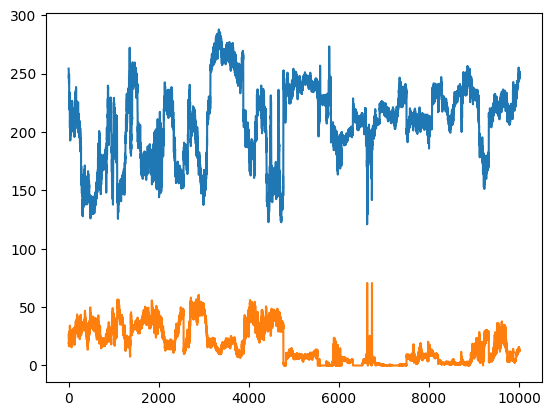

In [10]:
# 查看输出的最大最小值分布
import matplotlib.pyplot as plt

maxs,mins = [], []
for scene in scenes:
    print("=> processing ", scene.split('/')[-1])
    
    gt = sorted(Path(f"/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/{scene}/depth_gt").listdir("*.npy"))
    rgb = sorted(Path(f"/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/{scene}").listdir("*.jpg"))
    RMSEs, MAEs, AbsRels = [] ,[], []
    errors = []
    for gg,rr in tzip(gt,rgb):
        gt_d = np.load(gg)
        # pred = 1.0 - infer(rr)
        # pred = 1.0/infer(rr)
        output = infer(rr)
        maxs.append(output.max())
        mins.append(output.min())
        # pred = convert_func(infer(rr), gt_d)
        
plt.plot(maxs)
plt.plot(mins)
print("=> 最小值为",min(mins))

### 最小二乘的方法

In [9]:
RMSE_of_scenes, MAE_of_scenes, AbsRel_of_scenes = test_on_C3VD(inverse_LSq)


/tmp/ipykernel_3711125/4219017120.py:10: DeprecationWarning: .listdir is deprecated; use iterdir
  gt = sorted(Path(f"/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/{scene}/depth_gt").listdir("*.npy"))
/tmp/ipykernel_3711125/4219017120.py:11: DeprecationWarning: .listdir is deprecated; use iterdir
  rgb = sorted(Path(f"/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/{scene}").listdir("*.jpg"))


=> processing  scene_cecum_t1_a


  0%|          | 0/276 [00:00<?, ?it/s]

100%|██████████| 276/276 [01:49<00:00,  2.52it/s]


=> processing  scene_cecum_t1_b


 56%|█████▌    | 430/765 [02:51<02:14,  2.49it/s]

In [ ]:


verbose_C3VD(RMSE_of_scenes,MAE_of_scenes,AbsRel_of_scenes)


scene of  scene_cecum_t1_a
=> RMSE is  17.829247867506307 mm
=> MAE is  9.418483602638585 mm
=> AbsRel is  0.1929646727195748 mm

scene of  scene_cecum_t1_b
=> RMSE is  7.026601349090174 mm
=> MAE is  5.117044842223127 mm
=> AbsRel is  0.13453139686233753 mm

scene of  scene_cecum_t2_a
=> RMSE is  8.21161241390311 mm
=> MAE is  5.360630837941509 mm
=> AbsRel is  0.1414867453399597 mm

scene of  scene_cecum_t2_b
=> RMSE is  15.111704981125936 mm
=> MAE is  8.499367808986225 mm
=> AbsRel is  0.18076455413706016 mm

scene of  scene_cecum_t2_c
=> RMSE is  19.318353568134015 mm
=> MAE is  9.904500547188364 mm
=> AbsRel is  0.19660663481656682 mm

scene of  scene_cecum_t3_a
=> RMSE is  23.22126963559118 mm
=> MAE is  8.958053124429078 mm
=> AbsRel is  0.1742672652851263 mm

scene of  scene_cecum_t4_a
=> RMSE is  10.10857467707173 mm
=> MAE is  6.165222806710565 mm
=> AbsRel is  0.13990227939907118 mm

scene of  scene_cecum_t4_b
=> RMSE is  22.67491734483514 mm
=> MAE is  12.036890044791562 

In [ ]:
# for scene, RMSE,MAE,AbsRel in zip(scenes,RMSE_of_scenes, MAE_of_scenes, AbsRel_of_scenes):
#     print( scene.split('/')[-1])
#     print("=> RMSE is ",sum(RMSE)/len(RMSE))
#     print("=> MAE is ", sum(MAE)/len(MAE))
#     print("=> AbsRel is ", sum(AbsRel)/len(AbsRel))


RMSE_sum, MAE_sum, AbsRel_sum, count = 0.0, 0.0, 0.0, 0

RMSE_cecum_sum, MAE_cecum_sum, AbsRel_cecum_sum, count_cecum = 0.0, 0.0, 0.0, 0
RMSE_desc_sum, MAE_desc_sum, AbsRel_desc_sum, count_desc = 0.0, 0.0, 0.0, 0
RMSE_sigmoid_sum, MAE_sigmoid_sum, AbsRel_sigmoid_sum, count_sigmoid = 0.0, 0.0, 0.0, 0
RMSE_trans_sum, MAE_trans_sum, AbsRel_trans_sum, count_trans = 0.0, 0.0, 0.0, 0

for p,RMSEs,MAEs,AbsRels in zip(scenes,RMSE_of_scenes,MAE_of_scenes,AbsRel_of_scenes):
    name = p.split('/')[-1]
    print("\nscene of ", name)
    print("=> RMSE is ", sum(RMSEs)/len(RMSEs), 'mm')
    print("=> MAE is ", sum(MAEs)/len(MAEs), 'mm')
    print("=> AbsRel is ", sum(AbsRels)/len(AbsRels), 'mm')
    RMSE_sum += sum(RMSEs)
    MAE_sum += sum(MAEs)
    AbsRel_sum += sum(AbsRels)
    count += len(RMSEs)

    part_name = name.split('_')[1]
    if part_name == 'cecum':
        RMSE_cecum_sum += sum(RMSEs)
        MAE_cecum_sum += sum(MAEs)
        AbsRel_cecum_sum += sum(AbsRels)
        count_cecum += len(RMSEs)
    elif part_name == 'desc':
        RMSE_desc_sum += sum(RMSEs)
        MAE_desc_sum += sum(MAEs)
        AbsRel_desc_sum += sum(AbsRels)
        count_desc += len(RMSEs)
    elif part_name == 'sigmoid':
        RMSE_sigmoid_sum += sum(RMSEs)
        MAE_sigmoid_sum += sum(MAEs)
        AbsRel_sigmoid_sum += sum(AbsRels)
        count_sigmoid += len(RMSEs)
    elif part_name == 'trans':
        RMSE_trans_sum += sum(RMSEs)
        MAE_trans_sum += sum(MAEs)
        AbsRel_trans_sum += sum(AbsRels)
        count_trans += len(RMSEs)

print("\n C3VD numbers is ", count)

print("\n each part")
print("\n ----- cecum ------")
print("=> RMSE is ", RMSE_cecum_sum/count_cecum, 'mm')
print("=> MAE is ", MAE_cecum_sum/count_cecum, 'mm')
print("=> AbsRel is ", AbsRel_cecum_sum/count_cecum)

print("\n ----- desc ------")
print("=> RMSE is ", RMSE_desc_sum/count_desc, 'mm')
print("=> MAE is ", MAE_desc_sum/count_desc, 'mm')
print("=> AbsRel is ", AbsRel_desc_sum/count_desc)

print("\n ----- sigmoid ------")
print("=> RMSE is ", RMSE_sigmoid_sum/count_sigmoid, 'mm')
print("=> MAE is ", MAE_sigmoid_sum/count_sigmoid, 'mm')
print("=> AbsRel is ", AbsRel_sigmoid_sum/count_sigmoid)

print("\n ----- trans ------")
print("=> RMSE is ", RMSE_trans_sum/count_trans, 'mm')
print("=> MAE is ", MAE_trans_sum/count_trans, 'mm')
print("=> AbsRel is ", AbsRel_trans_sum/count_trans)

print("\n ----- all dataset -----")
print("=> RMSE is ", RMSE_sum/count, 'mm')
print("=> MAE is ", MAE_sum/count, 'mm')
print("=> AbsRel is ", AbsRel_sum/count)


### 直接倒数

In [11]:
RMSE_of_scenes, MAE_of_scenes, AbsRel_of_scenes = test_on_C3VD(inverse_direct)


/tmp/ipykernel_3492099/4219017120.py:10: DeprecationWarning: .listdir is deprecated; use iterdir
  gt = sorted(Path(f"/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/{scene}/depth_gt").listdir("*.npy"))
/tmp/ipykernel_3492099/4219017120.py:11: DeprecationWarning: .listdir is deprecated; use iterdir
  rgb = sorted(Path(f"/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/{scene}").listdir("*.jpg"))


=> processing  scene_cecum_t1_a


  0%|          | 0/276 [00:00<?, ?it/s]

100%|██████████| 276/276 [01:52<00:00,  2.46it/s]


=> processing  scene_cecum_t1_b


100%|██████████| 765/765 [05:11<00:00,  2.46it/s]


=> processing  scene_cecum_t2_a


100%|██████████| 370/370 [02:30<00:00,  2.45it/s]


=> processing  scene_cecum_t2_b


100%|██████████| 1142/1142 [07:43<00:00,  2.46it/s]


=> processing  scene_cecum_t2_c


100%|██████████| 595/595 [04:01<00:00,  2.46it/s]


=> processing  scene_cecum_t3_a


100%|██████████| 730/730 [04:56<00:00,  2.46it/s]


=> processing  scene_cecum_t4_a


100%|██████████| 465/465 [03:08<00:00,  2.46it/s]


=> processing  scene_cecum_t4_b


100%|██████████| 425/425 [02:52<00:00,  2.46it/s]


=> processing  scene_trans_t1_a


100%|██████████| 61/61 [00:24<00:00,  2.46it/s]


=> processing  scene_trans_t1_b


100%|██████████| 700/700 [04:44<00:00,  2.46it/s]


=> processing  scene_trans_t2_a


100%|██████████| 194/194 [01:19<00:00,  2.45it/s]


=> processing  scene_trans_t2_b


100%|██████████| 103/103 [00:41<00:00,  2.47it/s]


=> processing  scene_trans_t2_c


100%|██████████| 235/235 [01:35<00:00,  2.45it/s]


=> processing  scene_trans_t3_a


100%|██████████| 250/250 [01:42<00:00,  2.44it/s]


=> processing  scene_trans_t3_b


100%|██████████| 214/214 [01:26<00:00,  2.46it/s]


=> processing  scene_trans_t4_a


100%|██████████| 382/382 [02:35<00:00,  2.46it/s]


=> processing  scene_trans_t4_b


100%|██████████| 597/597 [04:29<00:00,  2.22it/s]


=> processing  scene_sigmoid_t1_a


100%|██████████| 700/700 [04:43<00:00,  2.47it/s]


=> processing  scene_sigmoid_t2_a


100%|██████████| 514/514 [03:21<00:00,  2.55it/s]


=> processing  scene_sigmoid_t3_a


100%|██████████| 613/613 [03:59<00:00,  2.56it/s]


=> processing  scene_sigmoid_t3_b


100%|██████████| 536/536 [03:29<00:00,  2.55it/s]


=> processing  scene_desc_t4_a


100%|██████████| 148/148 [00:57<00:00,  2.56it/s]

[]
=> [E] number is  0


In [12]:
verbose_C3VD(RMSE_of_scenes,MAE_of_scenes,AbsRel_of_scenes)


scene of  scene_cecum_t1_a
=> RMSE is  10.640139879463348 mm
=> MAE is  8.583918755309162 mm
=> AbsRel is  0.24407710922830156 mm

scene of  scene_cecum_t1_b
=> RMSE is  7.71589425855939 mm
=> MAE is  6.3250608400292645 mm
=> AbsRel is  0.18149006613035884 mm

scene of  scene_cecum_t2_a
=> RMSE is  7.81164852296574 mm
=> MAE is  6.288056559189658 mm
=> AbsRel is  0.1932250858097164 mm

scene of  scene_cecum_t2_b
=> RMSE is  9.932081478737231 mm
=> MAE is  8.223790428011275 mm
=> AbsRel is  0.23695639395337006 mm

scene of  scene_cecum_t2_c
=> RMSE is  10.671723126565347 mm
=> MAE is  8.724554863418135 mm
=> AbsRel is  0.25339203223205686 mm

scene of  scene_cecum_t3_a
=> RMSE is  15.681773540665658 mm
=> MAE is  11.301185647414385 mm
=> AbsRel is  0.30943378281452016 mm

scene of  scene_cecum_t4_a
=> RMSE is  11.775769382390335 mm
=> MAE is  9.069556620734337 mm
=> AbsRel is  0.2280793073418601 mm

scene of  scene_cecum_t4_b
=> RMSE is  10.603500704525324 mm
=> MAE is  8.5283682990952

### 我们的方式

In [ ]:
RMSE_of_scenes, MAE_of_scenes, AbsRel_of_scenes = test_on_C3VD(ours_conversion)


/tmp/ipykernel_3492099/4219017120.py:10: DeprecationWarning: .listdir is deprecated; use iterdir
  gt = sorted(Path(f"/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/{scene}/depth_gt").listdir("*.npy"))
/tmp/ipykernel_3492099/4219017120.py:11: DeprecationWarning: .listdir is deprecated; use iterdir
  rgb = sorted(Path(f"/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/{scene}").listdir("*.jpg"))


=> processing  scene_cecum_t1_a


 53%|█████▎    | 145/276 [00:56<00:51,  2.55it/s]

100%|██████████| 276/276 [01:48<00:00,  2.55it/s]


=> processing  scene_cecum_t1_b


100%|██████████| 765/765 [04:59<00:00,  2.55it/s]


=> processing  scene_cecum_t2_a


100%|██████████| 370/370 [02:24<00:00,  2.55it/s]


=> processing  scene_cecum_t2_b


100%|██████████| 1142/1142 [07:26<00:00,  2.56it/s]


=> processing  scene_cecum_t2_c


100%|██████████| 595/595 [03:52<00:00,  2.56it/s]


=> processing  scene_cecum_t3_a


100%|██████████| 730/730 [04:46<00:00,  2.55it/s]


=> processing  scene_cecum_t4_a


100%|██████████| 465/465 [03:02<00:00,  2.55it/s]


=> processing  scene_cecum_t4_b


100%|██████████| 425/425 [02:46<00:00,  2.55it/s]


=> processing  scene_trans_t1_a


100%|██████████| 61/61 [00:23<00:00,  2.56it/s]


=> processing  scene_trans_t1_b


100%|██████████| 700/700 [04:33<00:00,  2.56it/s]


=> processing  scene_trans_t2_a


100%|██████████| 194/194 [01:15<00:00,  2.55it/s]


=> processing  scene_trans_t2_b


100%|██████████| 103/103 [00:40<00:00,  2.56it/s]


=> processing  scene_trans_t2_c


100%|██████████| 235/235 [01:31<00:00,  2.56it/s]


=> processing  scene_trans_t3_a


100%|██████████| 250/250 [01:37<00:00,  2.56it/s]


=> processing  scene_trans_t3_b


100%|██████████| 214/214 [01:23<00:00,  2.56it/s]


=> processing  scene_trans_t4_a


100%|██████████| 382/382 [02:29<00:00,  2.56it/s]


=> processing  scene_trans_t4_b


 53%|█████▎    | 318/597 [02:04<01:49,  2.55it/s]

In [ ]:
verbose_C3VD(RMSE_of_scenes,MAE_of_scenes,AbsRel_of_scenes)


scene of  scene_cecum_t1_a
=> RMSE is  15.739084990016082 mm
=> MAE is  12.654090268086895 mm
=> AbsRel is  0.3820017043339739 mm

scene of  scene_cecum_t1_b
=> RMSE is  15.763242135782193 mm
=> MAE is  13.186728847655454 mm
=> AbsRel is  0.3704120518470275 mm

scene of  scene_cecum_t2_a
=> RMSE is  17.102805876738696 mm
=> MAE is  14.279528504424423 mm
=> AbsRel is  0.4408847439944122 mm

scene of  scene_cecum_t2_b
=> RMSE is  17.69925606847826 mm
=> MAE is  14.270243061731554 mm
=> AbsRel is  0.3712512794815195 mm

scene of  scene_cecum_t2_c
=> RMSE is  15.441612289824421 mm
=> MAE is  12.287622455747965 mm
=> AbsRel is  0.3339601335341256 mm

scene of  scene_cecum_t3_a
=> RMSE is  16.964209344335615 mm
=> MAE is  11.129443798188522 mm
=> AbsRel is  0.26459019039758874 mm

scene of  scene_cecum_t4_a
=> RMSE is  13.078814966033717 mm
=> MAE is  10.386736671375266 mm
=> AbsRel is  0.294873417326229 mm

scene of  scene_cecum_t4_b
=> RMSE is  16.936014438099274 mm
=> MAE is  12.91925385

### C3VD训练的方式

In [ ]:
def tmp(output, gt):
    return 1/(output+22.2)


RMSE_of_scenes, MAE_of_scenes, AbsRel_of_scenes = test_on_C3VD(tmp)



/tmp/ipykernel_2740646/4219017120.py:10: DeprecationWarning: .listdir is deprecated; use iterdir
  gt = sorted(Path(f"/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/{scene}/depth_gt").listdir("*.npy"))
/tmp/ipykernel_2740646/4219017120.py:11: DeprecationWarning: .listdir is deprecated; use iterdir
  rgb = sorted(Path(f"/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/{scene}").listdir("*.jpg"))


=> processing  scene_cecum_t1_a


  0%|          | 0/276 [00:00<?, ?it/s]

100%|██████████| 276/276 [01:44<00:00,  2.65it/s]


=> processing  scene_cecum_t2_a


100%|██████████| 370/370 [02:22<00:00,  2.60it/s]


=> processing  scene_cecum_t3_a


100%|██████████| 730/730 [04:43<00:00,  2.57it/s]


=> processing  scene_sigmoid_t3_a


100%|██████████| 613/613 [03:58<00:00,  2.57it/s]


=> processing  scene_trans_t2_a


100%|██████████| 194/194 [01:15<00:00,  2.57it/s]


=> processing  scene_trans_t3_a


100%|██████████| 250/250 [01:37<00:00,  2.57it/s]


=> processing  scene_trans_t4_a


100%|██████████| 382/382 [02:28<00:00,  2.57it/s]

[]
=> [E] number is  0


In [ ]:
verbose_C3VD(RMSE_of_scenes,MAE_of_scenes,AbsRel_of_scenes)


scene of  scene_cecum_t1_a
=> RMSE is  8.875117705325684 mm
=> MAE is  7.2564540892359295 mm
=> AbsRel is  0.2120099386549347 mm

scene of  scene_cecum_t2_a
=> RMSE is  6.872828282822919 mm
=> MAE is  5.643068007489002 mm
=> AbsRel is  0.1762393456654244 mm

scene of  scene_cecum_t3_a
=> RMSE is  12.386494797273853 mm
=> MAE is  9.599635201384727 mm
=> AbsRel is  0.31163919469363094 mm

scene of  scene_sigmoid_t3_a
=> RMSE is  4.550172360053519 mm
=> MAE is  3.6328910529016483 mm
=> AbsRel is  0.18706005355444658 mm

scene of  scene_trans_t2_a
=> RMSE is  13.042618388991079 mm
=> MAE is  7.807773574015183 mm
=> AbsRel is  0.26275036548329894 mm

scene of  scene_trans_t3_a
=> RMSE is  8.763266403435606 mm
=> MAE is  5.498043568034073 mm
=> AbsRel is  0.19693357684126025 mm

scene of  scene_trans_t4_a
=> RMSE is  7.385791161376384 mm
=> MAE is  5.391778039514789 mm
=> AbsRel is  0.23043362613566407 mm

 C3VD numbers is  2815

 each part

 ----- cecum ------
=> RMSE is  10.19957859979962

In [ ]:
# ours
RMSE_of_scenes, MAE_of_scenes, AbsRel_of_scenes = test_on_C3VD(ours_conversion)



=> processing  scene_cecum_t1_a


  0%|          | 0/276 [00:00<?, ?it/s]

=> processing  scene_cecum_t2_a


  0%|          | 0/370 [00:00<?, ?it/s]

=> processing  scene_cecum_t3_a


  0%|          | 0/730 [00:00<?, ?it/s]

=> processing  scene_sigmoid_t3_a


  0%|          | 0/613 [00:00<?, ?it/s]

=> processing  scene_trans_t2_a


  0%|          | 0/194 [00:00<?, ?it/s]

=> processing  scene_trans_t3_a


  0%|          | 0/250 [00:00<?, ?it/s]

=> processing  scene_trans_t4_a


  0%|          | 0/382 [00:00<?, ?it/s]

[]
=> [E] number is  0


In [ ]:
verbose_C3VD(RMSE_of_scenes,MAE_of_scenes,AbsRel_of_scenes)


scene of  scene_cecum_t1_a
=> RMSE is  14.109719694709373 mm
=> MAE is  11.125163295113646 mm
=> AbsRel is  0.2914492608821217 mm

scene of  scene_cecum_t2_a
=> RMSE is  10.825853788126306 mm
=> MAE is  8.754434049412561 mm
=> AbsRel is  0.2500682413166686 mm

scene of  scene_cecum_t3_a
=> RMSE is  16.99258897986953 mm
=> MAE is  11.92614020942523 mm
=> AbsRel is  0.3122619649725683 mm

scene of  scene_sigmoid_t3_a
=> RMSE is  6.547584583076271 mm
=> MAE is  5.15623233969438 mm
=> AbsRel is  0.2303611256827388 mm

scene of  scene_trans_t2_a
=> RMSE is  17.84967418730092 mm
=> MAE is  9.575233277602191 mm
=> AbsRel is  0.27168216977912957 mm

scene of  scene_trans_t3_a
=> RMSE is  12.158592457888458 mm
=> MAE is  7.133694389945469 mm
=> AbsRel is  0.22381556139471612 mm

scene of  scene_trans_t4_a
=> RMSE is  9.6786470034491 mm
=> MAE is  6.572169571932321 mm
=> AbsRel is  0.24579391878500673 mm

 C3VD numbers is  2815

 each part

 ----- cecum ------
=> RMSE is  14.756132625473313 mm


## SimCol数据集

In [ ]:
def test_on_SimCol(convert_func):
    
    # scene = 'cecum_t1_a'
    # scene = 'sigmoid_t1_a'
    RMSE_of_scenes, MAE_of_scenes = [], []
    AbsRel_of_scenes = []
    root_path = Path("/home/jiahan/jiahan/datasets/SimCol/SimCol3D4SC_Depth")

    with open(root_path/'all.txt', 'r') as f:
        lines = f.readlines()
    scenes = [root_path/line[:-1] for line in lines]

    for scene in scenes:
        print("=> processing ", scene.split('/')[-1])
        
        gt = sorted((scene/'depth_gt').listdir("*.npy"))
        rgb = sorted(scene.listdir("F*.png"))

        RMSEs, MAEs, AbsRels = [] ,[], []
        errors = []
        for gg,rr in tzip(gt,rgb):
            gt_d = np.load(gg)
            # pred = 1.0 - infer(rr)
            # pred = 1.0/infer(rr)
            pred = convert_func(infer(rr), gt_d)
            if(pred.max()>1000):
                errors.append(gg)
                continue
            
            scale = np.median(gt_d)/np.median(pred)
            # np.save(save_path/rr.split('/')[-1].split('.')[0]+'.npy',pred)
            pred *= scale
            
            RMSEs.append(rmsef(gt_d,pred))
            MAEs.append(maef(gt_d,pred))
            AbsRels.append(absrelf(gt_d,pred))
        RMSE_of_scenes.append(RMSEs)
        MAE_of_scenes.append(MAEs)
        AbsRel_of_scenes.append(AbsRels)
    print(errors)
    print("=> [E] number is ", len(errors))

    return RMSE_of_scenes, MAE_of_scenes, AbsRel_of_scenes

def verbose_SimCol(RMSEs_of_scenes,MAEs_of_scenes,AbsRel_of_scenes):
    # LSq 推理
    pred_paths = ["SyntheticColon_I", "SyntheticColon_II", "SyntheticColon_III"]
    RMSE_sum,MAE_sum,AbsRel_sum = 0.0,0.0,0.0
    count = 0

    for p,RMSEs,MAEs,AbsRels in zip(pred_paths,RMSEs_of_scenes,MAEs_of_scenes,AbsRel_of_scenes):
        if(len(RMSEs)==0): continue
        name = p.split('/')[-1]
        print("\nscene of ", name)
        print("=> RMSE is ", sum(RMSEs)/len(RMSEs), 'mm')
        print("=> MAE is ", sum(MAEs)/len(MAEs), 'mm')
        print("=> AbsRel is ", sum(AbsRels)/len(AbsRels), 'mm')
        RMSE_sum += sum(RMSEs)
        MAE_sum += sum(MAEs)
        AbsRel_sum += sum(AbsRels)
        count += len(RMSEs)

    print("all dataset")
    print("=> RMSE is ", RMSE_sum/count, 'mm')
    print("=> MAE is ", MAE_sum/count, 'mm')
    print("=> AbsRel is ", AbsRel_sum/count, 'mm')


### 最小二乘的方式

In [ ]:
RMSEs_of_scenes,MAEs_of_scenes,AbsRel_of_scenes = test_on_SimCol(inverse_LSq)


/tmp/ipykernel_2063693/2817329383.py:16: DeprecationWarning: .listdir is deprecated; use iterdir
  gt = sorted((scene/'depth_gt').listdir("*.npy"))
/tmp/ipykernel_2063693/2817329383.py:17: DeprecationWarning: .listdir is deprecated; use iterdir
  rgb = sorted(scene.listdir("F*.png"))


=> processing  Frames_S15


100%|███████████████████████████████████████| 1201/1201 [05:18<00:00,  3.78it/s]


=> processing  Frames_S7


100%|███████████████████████████████████████| 1201/1201 [05:20<00:00,  3.75it/s]


=> processing  Frames_S12


100%|███████████████████████████████████████| 1201/1201 [05:22<00:00,  3.73it/s]


=> processing  Frames_S13


100%|███████████████████████████████████████| 1201/1201 [06:16<00:00,  3.19it/s]


=> processing  Frames_S1


100%|███████████████████████████████████████| 1201/1201 [06:09<00:00,  3.25it/s]


=> processing  Frames_S4


100%|███████████████████████████████████████| 1201/1201 [06:00<00:00,  3.33it/s]


=> processing  Frames_S3


100%|███████████████████████████████████████| 1201/1201 [05:22<00:00,  3.72it/s]


=> processing  Frames_S2


100%|███████████████████████████████████████| 1201/1201 [05:54<00:00,  3.39it/s]


=> processing  Frames_S11


100%|███████████████████████████████████████| 1201/1201 [06:01<00:00,  3.32it/s]


=> processing  Frames_S14


100%|███████████████████████████████████████| 1201/1201 [06:33<00:00,  3.05it/s]


=> processing  Frames_S9


100%|███████████████████████████████████████| 1201/1201 [05:15<00:00,  3.80it/s]


=> processing  Frames_S6


100%|███████████████████████████████████████| 1201/1201 [05:15<00:00,  3.81it/s]


=> processing  Frames_S8


100%|███████████████████████████████████████| 1201/1201 [05:15<00:00,  3.81it/s]


=> processing  Frames_S5


100%|███████████████████████████████████████| 1201/1201 [05:14<00:00,  3.81it/s]


=> processing  Frames_S10


100%|███████████████████████████████████████| 1201/1201 [05:15<00:00,  3.81it/s]


=> processing  Frames_B12


100%|███████████████████████████████████████| 1201/1201 [05:15<00:00,  3.81it/s]


=> processing  Frames_B2


100%|███████████████████████████████████████| 1201/1201 [05:15<00:00,  3.81it/s]


=> processing  Frames_B1


100%|███████████████████████████████████████| 1201/1201 [05:14<00:00,  3.82it/s]


=> processing  Frames_B7


100%|███████████████████████████████████████| 1201/1201 [05:14<00:00,  3.82it/s]


=> processing  Frames_B13


100%|███████████████████████████████████████| 1201/1201 [05:14<00:00,  3.82it/s]


=> processing  Frames_B10


100%|███████████████████████████████████████| 1201/1201 [05:14<00:00,  3.82it/s]


=> processing  Frames_B4


 85%|████████████████████████████████▉      | 1015/1201 [04:25<00:48,  3.84it/s]/tmp/ipykernel_2063693/1958943548.py:46: RuntimeWarning: divide by zero encountered in divide
  return 1/(alpha*output + beta)
100%|███████████████████████████████████████| 1201/1201 [05:14<00:00,  3.82it/s]


=> processing  Frames_B8


100%|███████████████████████████████████████| 1201/1201 [05:13<00:00,  3.82it/s]


=> processing  Frames_B14


100%|███████████████████████████████████████| 1201/1201 [05:14<00:00,  3.82it/s]


=> processing  Frames_B5


100%|███████████████████████████████████████| 1201/1201 [05:14<00:00,  3.82it/s]


=> processing  Frames_B9


100%|███████████████████████████████████████| 1201/1201 [05:14<00:00,  3.82it/s]


=> processing  Frames_B6


100%|███████████████████████████████████████| 1201/1201 [05:14<00:00,  3.82it/s]


=> processing  Frames_B3


100%|███████████████████████████████████████| 1201/1201 [05:14<00:00,  3.82it/s]


=> processing  Frames_B15


100%|███████████████████████████████████████| 1201/1201 [05:14<00:00,  3.82it/s]


=> processing  Frames_B11


100%|███████████████████████████████████████| 1201/1201 [05:13<00:00,  3.82it/s]


=> processing  Frames_O3


100%|█████████████████████████████████████████| 601/601 [02:37<00:00,  3.82it/s]


=> processing  Frames_O2


100%|█████████████████████████████████████████| 601/601 [02:37<00:00,  3.81it/s]


=> processing  Frames_O1


100%|█████████████████████████████████████████| 601/601 [02:37<00:00,  3.81it/s]

[Path('/home/jiahan/jiahan/datasets/SimCol/SimCol3D4SC_Depth/SyntheticColon_III/Frames_O1/depth_gt/FrameBuffer_0054.npy'), Path('/home/jiahan/jiahan/datasets/SimCol/SimCol3D4SC_Depth/SyntheticColon_III/Frames_O1/depth_gt/FrameBuffer_0055.npy'), Path('/home/jiahan/jiahan/datasets/SimCol/SimCol3D4SC_Depth/SyntheticColon_III/Frames_O1/depth_gt/FrameBuffer_0056.npy'), Path('/home/jiahan/jiahan/datasets/SimCol/SimCol3D4SC_Depth/SyntheticColon_III/Frames_O1/depth_gt/FrameBuffer_0057.npy'), Path('/home/jiahan/jiahan/datasets/SimCol/SimCol3D4SC_Depth/SyntheticColon_III/Frames_O1/depth_gt/FrameBuffer_0058.npy'), Path('/home/jiahan/jiahan/datasets/SimCol/SimCol3D4SC_Depth/SyntheticColon_III/Frames_O1/depth_gt/FrameBuffer_0059.npy'), Path('/home/jiahan/jiahan/datasets/SimCol/SimCol3D4SC_Depth/SyntheticColon_III/Frames_O1/depth_gt/FrameBuffer_0060.npy'), Path('/home/jiahan/jiahan/datasets/SimCol/SimCol3D4SC_Depth/SyntheticColon_III/Frames_O1/depth_gt/FrameBuffer_0061.npy'), Path('/home/jiahan/jiah

In [ ]:
verbose_SimCol(RMSEs_of_scenes,MAEs_of_scenes,AbsRel_of_scenes)


scene of  SyntheticColon_I
=> RMSE is  10.049810026115841 mm
=> MAE is  4.149009159805269 mm
=> AbsRel is  0.13824609266229682 mm

scene of  SyntheticColon_II
=> RMSE is  11.882718901245088 mm
=> MAE is  4.686126861190634 mm
=> AbsRel is  0.14049208467759186 mm

scene of  SyntheticColon_III
=> RMSE is  10.679058746457576 mm
=> MAE is  4.306727474356076 mm
=> AbsRel is  0.1364445700478062 mm
all dataset
=> RMSE is  10.887913003787961 mm
=> MAE is  4.385489304665498 mm
=> AbsRel is  0.13839375463879466 mm


### 直接取倒数的方式

In [ ]:
RMSEs_of_scenes,MAEs_of_scenes,AbsRel_of_scenes = test_on_SimCol(inverse_direct)


/tmp/ipykernel_1221765/3488465206.py:16: DeprecationWarning: .listdir is deprecated; use iterdir
  gt = sorted((scene/'depth_gt').listdir("*.npy"))
/tmp/ipykernel_1221765/3488465206.py:17: DeprecationWarning: .listdir is deprecated; use iterdir
  rgb = sorted(scene.listdir("F*.png"))


=> processing  Frames_S15


100%|███████████████████████████████████████| 1201/1201 [05:12<00:00,  3.84it/s]


=> processing  Frames_S7


100%|███████████████████████████████████████| 1201/1201 [05:13<00:00,  3.83it/s]


=> processing  Frames_S12


100%|███████████████████████████████████████| 1201/1201 [05:17<00:00,  3.79it/s]


=> processing  Frames_S13


100%|███████████████████████████████████████| 1201/1201 [05:16<00:00,  3.79it/s]


=> processing  Frames_S1


100%|███████████████████████████████████████| 1201/1201 [05:16<00:00,  3.79it/s]


=> processing  Frames_S4


100%|███████████████████████████████████████| 1201/1201 [05:16<00:00,  3.79it/s]


=> processing  Frames_S3


100%|███████████████████████████████████████| 1201/1201 [05:16<00:00,  3.79it/s]


=> processing  Frames_S2


100%|███████████████████████████████████████| 1201/1201 [05:16<00:00,  3.79it/s]


=> processing  Frames_S11


100%|███████████████████████████████████████| 1201/1201 [05:16<00:00,  3.79it/s]


=> processing  Frames_S14


100%|███████████████████████████████████████| 1201/1201 [05:16<00:00,  3.79it/s]


=> processing  Frames_S9


100%|███████████████████████████████████████| 1201/1201 [05:21<00:00,  3.74it/s]


=> processing  Frames_S6


100%|███████████████████████████████████████| 1201/1201 [05:17<00:00,  3.78it/s]


=> processing  Frames_S8


100%|███████████████████████████████████████| 1201/1201 [05:16<00:00,  3.79it/s]


=> processing  Frames_S5


100%|███████████████████████████████████████| 1201/1201 [05:16<00:00,  3.79it/s]


=> processing  Frames_S10


100%|███████████████████████████████████████| 1201/1201 [05:16<00:00,  3.79it/s]


=> processing  Frames_B12


100%|███████████████████████████████████████| 1201/1201 [05:16<00:00,  3.80it/s]


=> processing  Frames_B2


100%|███████████████████████████████████████| 1201/1201 [05:17<00:00,  3.78it/s]


=> processing  Frames_B1


100%|███████████████████████████████████████| 1201/1201 [05:17<00:00,  3.78it/s]


=> processing  Frames_B7


100%|███████████████████████████████████████| 1201/1201 [05:17<00:00,  3.78it/s]


=> processing  Frames_B13


100%|███████████████████████████████████████| 1201/1201 [05:17<00:00,  3.78it/s]


=> processing  Frames_B10


100%|███████████████████████████████████████| 1201/1201 [05:17<00:00,  3.78it/s]


=> processing  Frames_B4


100%|███████████████████████████████████████| 1201/1201 [05:17<00:00,  3.78it/s]


=> processing  Frames_B8


100%|███████████████████████████████████████| 1201/1201 [05:17<00:00,  3.78it/s]


=> processing  Frames_B14


100%|███████████████████████████████████████| 1201/1201 [05:17<00:00,  3.78it/s]


=> processing  Frames_B5


100%|███████████████████████████████████████| 1201/1201 [05:16<00:00,  3.79it/s]


=> processing  Frames_B9


100%|███████████████████████████████████████| 1201/1201 [05:12<00:00,  3.84it/s]


=> processing  Frames_B6


100%|███████████████████████████████████████| 1201/1201 [05:10<00:00,  3.86it/s]


=> processing  Frames_B3


100%|███████████████████████████████████████| 1201/1201 [05:10<00:00,  3.86it/s]


=> processing  Frames_B15


100%|███████████████████████████████████████| 1201/1201 [05:10<00:00,  3.86it/s]


=> processing  Frames_B11


100%|███████████████████████████████████████| 1201/1201 [05:10<00:00,  3.86it/s]


=> processing  Frames_O3


100%|█████████████████████████████████████████| 601/601 [02:35<00:00,  3.86it/s]


=> processing  Frames_O2


100%|█████████████████████████████████████████| 601/601 [02:36<00:00,  3.85it/s]


=> processing  Frames_O1


100%|█████████████████████████████████████████| 601/601 [02:36<00:00,  3.84it/s]


In [ ]:
verbose_SimCol(RMSEs_of_scenes,MAEs_of_scenes,AbsRel_of_scenes)


scene of  SyntheticColon_I
=> RMSE is  8.72470381531181 mm
=> MAE is  5.332914312394172 mm
=> AbsRel is  0.2116181990536017 mm

scene of  SyntheticColon_II
=> RMSE is  8.856424665187083 mm
=> MAE is  5.450993703880874 mm
=> AbsRel is  0.20595378059440478 mm

scene of  SyntheticColon_III
=> RMSE is  8.985074721441345 mm
=> MAE is  5.440673914274396 mm
=> AbsRel is  0.21197771546374303 mm
all dataset
=> RMSE is  8.855401067313412 mm
=> MAE is  5.408193976849813 mm
=> AbsRel is  0.20984989837058315 mm


### 我们的方式

In [ ]:
RMSEs_of_scenes,MAEs_of_scenes,AbsRel_of_scenes = test_on_SimCol(ours_conversion)


/tmp/ipykernel_1221765/3488465206.py:16: DeprecationWarning: .listdir is deprecated; use iterdir
  gt = sorted((scene/'depth_gt').listdir("*.npy"))
/tmp/ipykernel_1221765/3488465206.py:17: DeprecationWarning: .listdir is deprecated; use iterdir
  rgb = sorted(scene.listdir("F*.png"))


=> processing  Frames_S15


100%|███████████████████████████████████████| 1201/1201 [05:17<00:00,  3.78it/s]


=> processing  Frames_S7


100%|███████████████████████████████████████| 1201/1201 [05:12<00:00,  3.84it/s]


=> processing  Frames_S12


100%|███████████████████████████████████████| 1201/1201 [05:10<00:00,  3.87it/s]


=> processing  Frames_S13


100%|███████████████████████████████████████| 1201/1201 [05:10<00:00,  3.87it/s]


=> processing  Frames_S1


100%|███████████████████████████████████████| 1201/1201 [05:10<00:00,  3.87it/s]


=> processing  Frames_S4


100%|███████████████████████████████████████| 1201/1201 [05:10<00:00,  3.87it/s]


=> processing  Frames_S3


100%|███████████████████████████████████████| 1201/1201 [05:10<00:00,  3.87it/s]


=> processing  Frames_S2


100%|███████████████████████████████████████| 1201/1201 [05:10<00:00,  3.87it/s]


=> processing  Frames_S11


100%|███████████████████████████████████████| 1201/1201 [05:10<00:00,  3.87it/s]


=> processing  Frames_S14


100%|███████████████████████████████████████| 1201/1201 [05:10<00:00,  3.87it/s]


=> processing  Frames_S9


100%|███████████████████████████████████████| 1201/1201 [05:10<00:00,  3.87it/s]


=> processing  Frames_S6


100%|███████████████████████████████████████| 1201/1201 [05:10<00:00,  3.87it/s]


=> processing  Frames_S8


100%|███████████████████████████████████████| 1201/1201 [05:11<00:00,  3.86it/s]


=> processing  Frames_S5


100%|███████████████████████████████████████| 1201/1201 [05:18<00:00,  3.77it/s]


=> processing  Frames_S10


100%|███████████████████████████████████████| 1201/1201 [05:18<00:00,  3.77it/s]


=> processing  Frames_B12


100%|███████████████████████████████████████| 1201/1201 [05:12<00:00,  3.84it/s]


=> processing  Frames_B2


100%|███████████████████████████████████████| 1201/1201 [05:11<00:00,  3.85it/s]


=> processing  Frames_B1


100%|███████████████████████████████████████| 1201/1201 [05:11<00:00,  3.85it/s]


=> processing  Frames_B7


100%|███████████████████████████████████████| 1201/1201 [05:11<00:00,  3.85it/s]


=> processing  Frames_B13


100%|███████████████████████████████████████| 1201/1201 [05:11<00:00,  3.85it/s]


=> processing  Frames_B10


100%|███████████████████████████████████████| 1201/1201 [05:11<00:00,  3.85it/s]


=> processing  Frames_B4


100%|███████████████████████████████████████| 1201/1201 [05:11<00:00,  3.85it/s]


=> processing  Frames_B8


100%|███████████████████████████████████████| 1201/1201 [05:10<00:00,  3.87it/s]


=> processing  Frames_B14


100%|███████████████████████████████████████| 1201/1201 [05:10<00:00,  3.87it/s]


=> processing  Frames_B5


100%|███████████████████████████████████████| 1201/1201 [05:10<00:00,  3.87it/s]


=> processing  Frames_B9


100%|███████████████████████████████████████| 1201/1201 [05:10<00:00,  3.87it/s]


=> processing  Frames_B6


100%|███████████████████████████████████████| 1201/1201 [05:09<00:00,  3.87it/s]


=> processing  Frames_B3


100%|███████████████████████████████████████| 1201/1201 [05:09<00:00,  3.87it/s]


=> processing  Frames_B15


100%|███████████████████████████████████████| 1201/1201 [05:09<00:00,  3.87it/s]


=> processing  Frames_B11


100%|███████████████████████████████████████| 1201/1201 [05:09<00:00,  3.87it/s]


=> processing  Frames_O3


100%|█████████████████████████████████████████| 601/601 [02:35<00:00,  3.87it/s]


=> processing  Frames_O2


100%|█████████████████████████████████████████| 601/601 [02:37<00:00,  3.82it/s]


=> processing  Frames_O1


100%|█████████████████████████████████████████| 601/601 [02:38<00:00,  3.79it/s]


In [ ]:
verbose_SimCol(RMSEs_of_scenes,MAEs_of_scenes,AbsRel_of_scenes)


scene of  SyntheticColon_I
=> RMSE is  8.312206980185648 mm
=> MAE is  5.119657829246475 mm
=> AbsRel is  0.20955503647004667 mm

scene of  SyntheticColon_II
=> RMSE is  8.247975828616415 mm
=> MAE is  5.173713494700947 mm
=> AbsRel is  0.20969508252689711 mm

scene of  SyntheticColon_III
=> RMSE is  8.634561389773216 mm
=> MAE is  5.396646174950786 mm
=> AbsRel is  0.22237380900196702 mm
all dataset
=> RMSE is  8.39824806619176 mm
=> MAE is  5.23000583296607 mm
=> AbsRel is  0.2138746426663036 mm


### 训练的方式

In [ ]:
def tmp(output, gt):
    return 1/(output+22.2)

RMSEs_of_scenes,MAEs_of_scenes,AbsRel_of_scenes = test_on_SimCol(tmp)


In [ ]:
verbose_SimCol(RMSEs_of_scenes,MAEs_of_scenes,AbsRel_of_scenes)

## 找图片验证

11.496522329339767


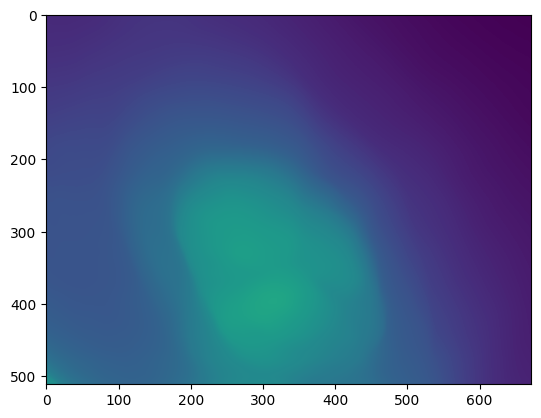

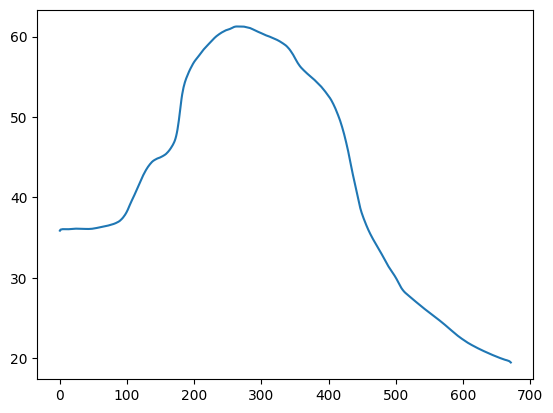

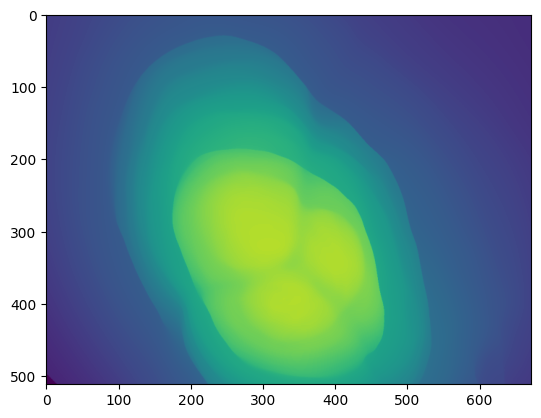

In [19]:

def apply_cmap(y):
    y = y*255
    y = y.clip(0,255)
    y = y.astype(np.uint8)
    return cv2.applyColorMap(y,cv2.COLORMAP_VIRIDIS)


def norm_minmax(y):
    return (y-y.min())/(y.max()-y.min())


file_path = "/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t1_a/00031.jpg"
output = infer(file_path)
gt = np.load("/home/jiahan/jiahan/datasets/C3VD/.dataset4SCDepth/scene_cecum_t1_a/depth_gt/00031.npy")
# cv2.imwrite("/home/jiahan/jiahan/datasets/论文/imgs/不稳定/cecum_t1_a_00031_depthanything.png", apply_cmap(norm_minmax(output)))
lsq_depth = inverse_LSq(output,gt)
plt.imshow(lsq_depth,vmax=100)
plt.figure()
plt.plot(lsq_depth[300])
# cv2.imwrite("/home/jiahan/jiahan/datasets/论文/imgs/不稳定/cecum_t1_a_00031_depthanything_lsq.png", apply_cmap(lsq_depth/100.0))

print((abs(lsq_depth-gt)).mean())

plt.figure()
plt.imshow(gt,vmax=100)

0.0 248.49052


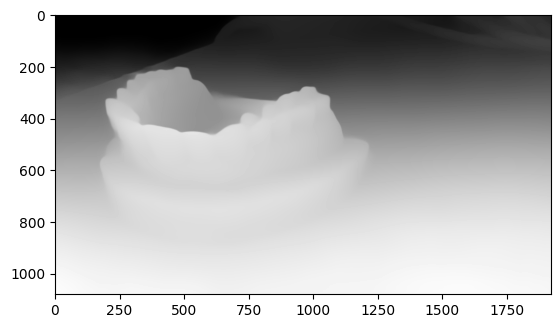

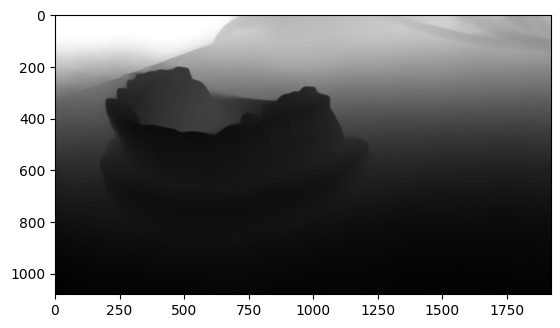

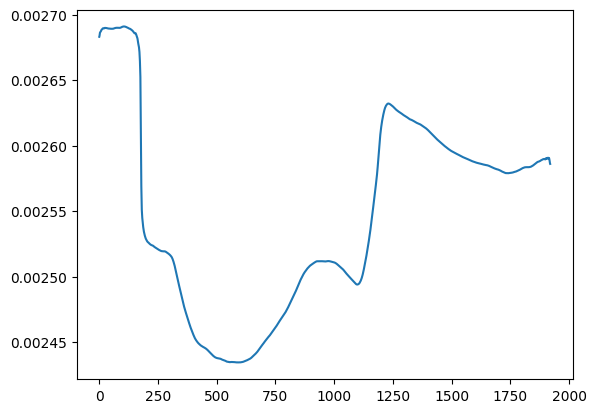

In [11]:
filename = "/home/jiahan/jiahan/codes/Depth-Anything/images/1.jpg"
depth = infer(filename)
plt.imshow(depth, cmap='gray')
print(depth.min(), depth.max())

depth = 1/(depth+200.0)
plt.figure()
plt.imshow(depth, cmap='gray')

plt.figure()
plt.plot(depth[600])